<a href="https://colab.research.google.com/github/String-ru/AIFFEL_quest_cr/blob/main/Exploration/Quest02_GPU%EB%B6%80%EC%A1%B1_0411_better_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 수정사항
### bad -> better be good -> better(현 파일)

### 1. 더 큰 은닉층 크기 (latent_dim = 512)

이전 코드의 latent_dim이 256이었던 것에 비해, 이 코드에서는 512로 증가 => 모델이 더 많은 정보를 저장하고 더 복잡한 관계를 학습

### 2. 더 깊은 양방향 LSTM 레이어 (인코더)

인코더에 두 개의 Bidirectional(layers.LSTM(...)) 레이어가 순차적으로 적용 => 양방향 LSTM으로 텍스트의 앞뒤 문맥을 모두 고려

### 3. Teacher Forcing 비율 조정 콜백 함수
TeacherForcingScheduler라는 사용자 정의 콜백 함수 => 학습 에포크가 진행됨에 따라 Teacher Forcing 비율을 점진적으로 감소시켜 모델이 점차 자신의 예측에 의존하여 요약을 생성하도록 유도

Installing summa...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=209d99a28435f704bd34d174ae398209834759fa388a996253de1f769225caef
  Stored in directory: /root/.cache/pip/wheels/10/2d/7a/abce87c4ea233f8dcca0d99b740ac0257eced1f99a124a0e1f
Successfully built summa
NLTK Version: 3.9.1
TensorFlow Version: 2.18.0
Pandas Version: 2.2.2
Summa Version: 1.2.0


Dataset loaded. Displaying 5 random samples:
                                               headlines  \
73589  Another email links Trump campaign to Putin: R...   
1918   BEST staff ends strike after 9 days as HC appo...   
48292  UK spent Ã¢ÂÂ¹90,000 to deliver 6-page Brexit...   
44189  Bangladesh plane carrying 71 people crashes at...   
1565   CEO of JPMorgan, which posted $32bn profit in ...   

                                                    text  
73589  US Congressiona

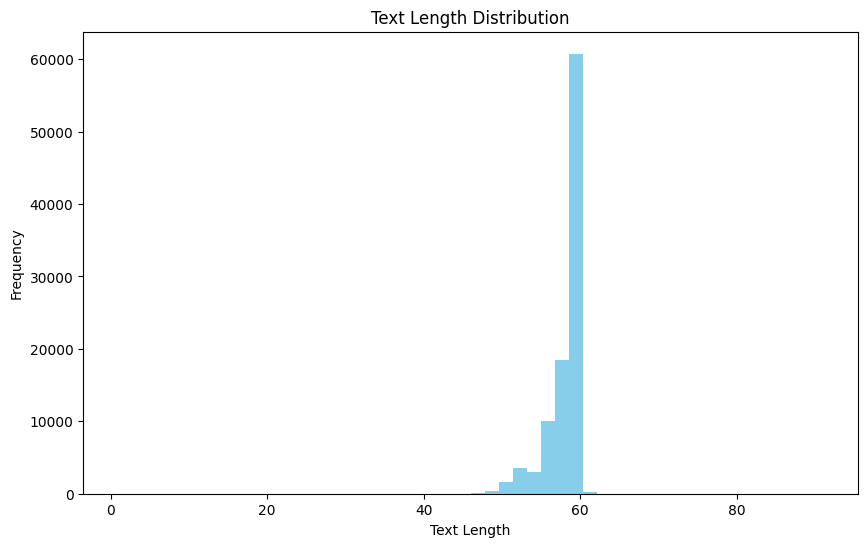

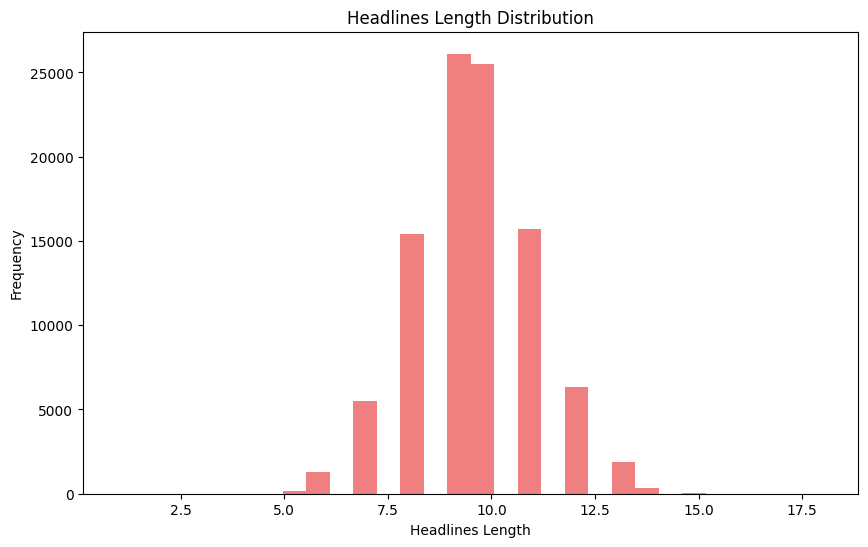


Most common words in Text: [('the', 333652), ('to', 144588), ('a', 137070), ('in', 128523), ('of', 121203), ('and', 106392), ('on', 71346), ('has', 56232), ('for', 55333), ('that', 50298), ('was', 47259), ('is', 40428), ('he', 35032), ('by', 34829), ('said', 33008), ('with', 32692), ('his', 31159), ('after', 28223), ('from', 28024), ('as', 27762)]
Most common words in Headlines: [('to', 31291), ('in', 26194), ('for', 15284), ('of', 13212), ('on', 12543), ('with', 5674), ('a', 5186), ('after', 5154), ('at', 5051), ('from', 4522), ('over', 4395), ('as', 4128), ('by', 4022), ('us', 3954), ('the', 3771), ('india', 3663), ('not', 2983), ('be', 2982), ('is', 2977), ('man', 2968)]


In [1]:
from importlib.metadata import version
import nltk
import tensorflow as tf
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from collections import Counter

# Summa 설치
print("Installing summa...")
!pip install summa
import summa

print("NLTK Version:", nltk.__version__)
print("TensorFlow Version:", tf.__version__)
print("Pandas Version:", pd.__version__)
print("Summa Version:", version('summa'))

# 데이터 다운로드 및 로드
print("\nDownloading the dataset...")
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print("\nDataset loaded. Displaying 5 random samples:")
print(data.sample(5))

# 데이터 분석
print("\n--- 데이터 분석 ---")
print("\n전체 데이터 개수:", len(data))
print("\nText 열 null 값 개수:", data['text'].isnull().sum())
print("Headlines 열 null 값 개수:", data['headlines'].isnull().sum())

# 텍스트 길이 분포 확인
text_len = data['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(text_len, bins=50, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# 헤드라인 길이 분포 확인
headlines_len = data['headlines'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(headlines_len, bins=30, color='lightcoral')
plt.title('Headlines Length Distribution')
plt.xlabel('Headlines Length')
plt.ylabel('Frequency')
plt.show()

# 가장 자주 등장하는 단어 확인 (Text)
all_text_words = ' '.join(data['text']).lower().split()
text_word_counts = Counter(all_text_words)
most_common_text_words = text_word_counts.most_common(20)
print("\nMost common words in Text:", most_common_text_words)

# 가장 자주 등장하는 단어 확인 (Headlines)
all_headlines_words = ' '.join(data['headlines']).lower().split()
headlines_word_counts = Counter(all_headlines_words)
most_common_headlines_words = headlines_word_counts.most_common(20)
print("Most common words in Headlines:", most_common_headlines_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


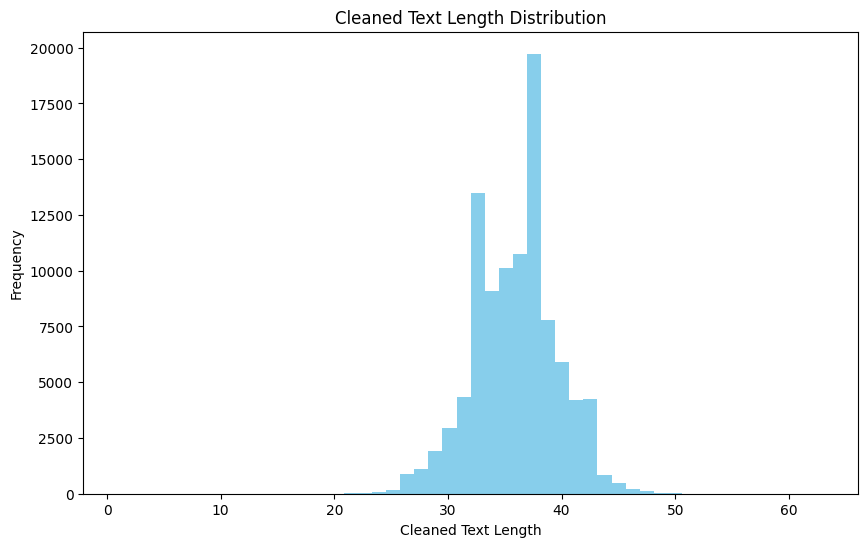

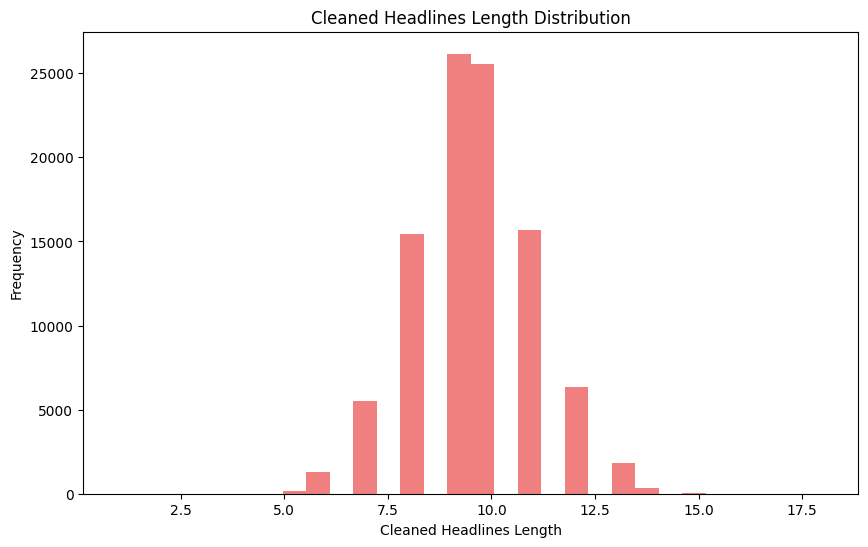

sostoken index: 25742, eostoken index: 25743

--- 데이터 전처리 완료 ---
Padded Text (Train) shape: (88560, 100)
Padded Text (Validation) shape: (9841, 100)
Padded Decoder Input (Train) shape: (88560, 20)
Padded Decoder Input (Validation) shape: (9841, 20)
Padded Decoder Target (Train) shape: (88560, 20)
Padded Decoder Target (Validation) shape: (9841, 20)
Text Vocabulary Size: 120191
Headlines Vocabulary Size: 44555


In [2]:
import re
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([w for w in text.split() if len(w) > 1 and w not in stop_words]) # 불용어 제거
    return text

def preprocess_headlines(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# 전처리 적용
data['cleaned_text'] = data['text'].apply(preprocess_text)
data['cleaned_headlines'] = data['headlines'].apply(preprocess_headlines)

# 빈 값 제거
data.replace('', float('NaN'), inplace=True)
data.dropna(axis=0, inplace=True)

# 텍스트 및 헤드라인 길이 분포 재확인 (전처리 후)
cleaned_text_len = data['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(cleaned_text_len, bins=50, color='skyblue')
plt.title('Cleaned Text Length Distribution')
plt.xlabel('Cleaned Text Length')
plt.ylabel('Frequency')
plt.show()

cleaned_headlines_len = data['cleaned_headlines'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(cleaned_headlines_len, bins=30, color='lightcoral')
plt.title('Cleaned Headlines Length Distribution')
plt.xlabel('Cleaned Headlines Length')
plt.ylabel('Frequency')
plt.show()

# 토큰화 및 패딩
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len_text = 100
max_len_headlines = 20

# Text 토크나이저
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(data['cleaned_text'])
text_sequences = text_tokenizer.texts_to_sequences(data['cleaned_text'])
padded_text = pad_sequences(text_sequences, maxlen=max_len_text, padding='post')
text_vocab_size = len(text_tokenizer.word_index) + 1

### 여기부터 수정

# 헤드라인 토크나이저 - 특수 토큰 사전 추가
headlines_tokenizer = Tokenizer(oov_token='<OOV>')
# 특수 토큰을 위한 텍스트 데이터 준비
special_tokens = ['sostoken', 'eostoken']
all_headlines = list(data['cleaned_headlines'])
# 토크나이저 학습
headlines_tokenizer.fit_on_texts(special_tokens + all_headlines)

# 특수 토큰 인덱스 확인
sostoken_index = headlines_tokenizer.word_index['sostoken']
eostoken_index = headlines_tokenizer.word_index['eostoken']
print(f"sostoken index: {sostoken_index}, eostoken index: {eostoken_index}")

# 일반 헤드라인 시퀀스 변환
headlines_sequences = headlines_tokenizer.texts_to_sequences(data['cleaned_headlines'])
padded_headlines = pad_sequences(headlines_sequences, maxlen=max_len_headlines, padding='post')

# 디코더 입력 시퀀스 생성 (시작 토큰 추가)
decoder_input_sequences = []
for seq in headlines_sequences:
    decoder_input_sequences.append([sostoken_index] + seq)
padded_decoder_input = pad_sequences(decoder_input_sequences, maxlen=max_len_headlines, padding='post')

# 디코더 타겟 시퀀스 생성 (종료 토큰 추가)
decoder_target_sequences = []
for seq in headlines_sequences:
    decoder_target_sequences.append(seq + [eostoken_index])
padded_decoder_target = pad_sequences(decoder_target_sequences, maxlen=max_len_headlines, padding='post')

# 어휘 크기 업데이트
headlines_vocab_size = len(headlines_tokenizer.word_index) + 1

### 여기까지 수정

decoder_target_sequences = headlines_tokenizer.texts_to_sequences(data['cleaned_headlines'])
padded_decoder_target = pad_sequences(decoder_target_sequences, maxlen=max_len_headlines, padding='post')

# 데이터셋 분리
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(padded_text, padded_decoder_target, test_size=0.1, random_state=42)
x_decoder_train, x_decoder_val, y_decoder_train, y_decoder_val = train_test_split(padded_decoder_input, padded_decoder_target, test_size=0.1, random_state=42)

print("\n--- 데이터 전처리 완료 ---")
print("Padded Text (Train) shape:", x_train.shape)
print("Padded Text (Validation) shape:", x_val.shape)
print("Padded Decoder Input (Train) shape:", x_decoder_train.shape)
print("Padded Decoder Input (Validation) shape:", x_decoder_val.shape)
print("Padded Decoder Target (Train) shape:", y_train.shape)
print("Padded Decoder Target (Validation) shape:", y_val.shape)
print("Text Vocabulary Size:", text_vocab_size)
print("Headlines Vocabulary Size:", headlines_vocab_size)

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

K.clear_session()
latent_dim = 512  # 더 큰 은닉층 크기

# 인코더
encoder_inputs = layers.Input(shape=(max_len_text,))
enc_emb = layers.Embedding(text_vocab_size, latent_dim)(encoder_inputs)

# 더 깊은 양방향 LSTM 레이어
encoder_lstm1 = layers.Bidirectional(layers.LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_outputs1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = layers.Bidirectional(layers.LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_outputs2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_outputs1)

# 최종 은닉 상태 및 셀 상태 (양방향 LSTM의 상태 연결)
state_h = layers.Concatenate()([forward_h2, backward_h2])
state_c = layers.Concatenate()([forward_c2, backward_c2])

encoder_outputs = encoder_outputs2

# 디코더
decoder_inputs = layers.Input(shape=(None,))
dec_emb_layer = layers.Embedding(headlines_vocab_size, latent_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더 LSTM (인코더의 최종 은닉 상태 크기에 맞춰 조정)
decoder_lstm = layers.LSTM(latent_dim * 2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 메커니즘
attention_layer = layers.AdditiveAttention(name='attention_layer')
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
decoder_concat_input = layers.Concatenate(axis=-1)([decoder_outputs, attention_outputs])

# 출력층
decoder_dense = layers.TimeDistributed(layers.Dense(headlines_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# 모델 정의
model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 512)  │ 61,537,792 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 100,      │  4,198,400 │ embedding[0][0]   │
│ (Bidirectional)     │ 1024), (None,     │            │                   │
│                     │ 512), (None,      │            │                   │
│                     │ 512), (None,      │            │                   │
│                     │ 512), (None,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ [(None, 100,      │  6,295,552 │ bidirectional[0]… │
│ (Bidirectional)     │ 1024), (None,     │            │                   │
│                     │ 512), (None,      │            │                   │
│                     │ 512), (None,      │            │                   │
│                     │ 512), (None,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 512) │ 22,812,160 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1024)      │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1024)      │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, None,     │  6,295,552 │ embedding_1[0][0… │
│                     │ 1024), (None,     │            │ concatenate[0][0… │
│                     │ 1024), (None,     │            │ concatenate_1[0]… │
│                     │ 1024)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None,      │      1,024 │ lstm_2[0][0],     │
│ (AdditiveAttention) │ 1024)             │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, None,      │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │ 2048)             │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │ 91,293,195 │ concatenate_2[0]… │
│ (TimeDistributed)   │ 44555)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 192,433,675 (734.08 MB)

 Trainable params: 192,433,675 (734.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 컴파일
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# Teacher Forcing 비율 조정을 위한 콜백 함수 정의
class TeacherForcingScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_ratio=1.0, decay_rate=0.9, decay_steps=1):
        super(TeacherForcingScheduler, self).__init__()
        self.initial_ratio = initial_ratio
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.current_ratio = initial_ratio
        self.step = 0

    def on_epoch_begin(self, epoch, logs=None):
        if epoch > 0 and epoch % self.decay_steps == 0:
            self.current_ratio *= self.decay_rate
        print(f"Epoch {epoch + 1}: Teacher Forcing Ratio = {self.current_ratio:.4f}")

    def on_train_batch_begin(self, batch, logs=None):
        # 모델 학습 시 Teacher Forcing 적용 여부를 결정하는 로직을 여기에 구현할 수 있습니다.
        # 하지만 Keras의 fit 메서드에서는 직접적으로 Teacher Forcing 비율을 제어하기 어렵습니다.
        # 이를 구현하려면 사용자 정의 학습 루프를 작성해야 합니다.
        # 여기서는 Teacher Forcing 비율을 단순히 로깅하고, 실제 적용은 외부에서 처리해야 합니다.
        pass

# Teacher Forcing 스케줄러 인스턴스 생성
tfs_callback = TeacherForcingScheduler(initial_ratio=1.0, decay_rate=0.98, decay_steps=1)

history = model.fit(
    [x_train, x_decoder_train],
    y_train.reshape((-1, y_train.shape[1], 1)),
    epochs=15,
    callbacks=[es, tfs_callback],  # Teacher Forcing 스케줄러 추가
    batch_size=64,
    validation_data=([x_val, x_decoder_val], y_val.reshape((-1, y_val.shape[1], 1)))
)

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 예측을 위한 모델 재구성 (인코더)
encoder_model = models.Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 예측을 위한 모델 재구성 (디코더)
decoder_state_input_h = layers.Input(shape=(latent_dim * 2,))  # 인코더 상태 크기에 맞춰 조정
decoder_state_input_c = layers.Input(shape=(latent_dim * 2,))  # 인코더 상태 크기에 맞춰 조정
decoder_hidden_state_input = layers.Input(shape=(max_len_text, latent_dim * 2,)) # 인코더 출력 크기에 맞춰 조정

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
attention_outputs_inf = attention_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_concat_input_inf = layers.Concatenate(axis=-1)([decoder_outputs2, attention_outputs_inf])
decoder_outputs2 = decoder_dense(decoder_concat_input_inf)
decoder_model = models.Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2, state_h2, state_c2]
)

Epoch 1: Teacher Forcing Ratio = 1.0000
Epoch 1/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 906s 644ms/step - loss: 4.2048 - val_loss: 3.8235
Epoch 2: Teacher Forcing Ratio = 0.9800
Epoch 2/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 908s 637ms/step - loss: 3.7538 - val_loss: 3.6741
Epoch 3: Teacher Forcing Ratio = 0.9604
Epoch 3/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 937s 648ms/step - loss: 3.5927 - val_loss: 3.4927
Epoch 4: Teacher Forcing Ratio = 0.9412
Epoch 4/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 924s 649ms/step - loss: 3.3545 - val_loss: 3.2788
Epoch 5: Teacher Forcing Ratio = 0.9224
Epoch 5/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 922s 650ms/step - loss: 3.1068 - val_loss: 3.1226
Epoch 6: Teacher Forcing Ratio = 0.9039
Epoch 6/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 910s 641ms/step - loss: 2.8895 - val_loss: 3.0254
Epoch 7: Teacher Forcing Ratio = 0.8858
Epoch 7/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 922s 641ms/step - loss: 2.6942 - val_loss: 2.9433
Epoch 8: Teacher Forcing Ratio = 0.8681
Epoch 8/15
1384/1384 ━━━━━━━━━━━━━━━